In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

tf.config.list_physical_devices()


2022-08-08 22:49:27.063158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:49:27.067593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:49:27.067814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def get_minst_model():

    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)

    model = keras.Model(inputs, outputs)

    return model

In [3]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

**Standard Workflow**

In [4]:
model = get_minst_model()

model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

2022-08-08 22:49:27.440806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 22:49:27.441711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:49:27.442196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 22:49:27.442401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2947 - accuracy: 0.9128 - val_loss: 0.1542 - val_accuracy: 0.9552
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1656 - accuracy: 0.9535 - val_loss: 0.1119 - val_accuracy: 0.9694
Epoch 3/3
313/313 [==============================] - 0s 910us/step


**Custom Metrics**

In [5]:
class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true-y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [6]:
model2 = get_minst_model()

model2.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

model2.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

test_metrics = model2.evaluate(test_images, test_labels)
predictions = model2.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2915 - accuracy: 0.9132 - rmse: 7.1860 - val_loss: 0.1540 - val_accuracy: 0.9560 - val_rmse: 7.3599
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1651 - accuracy: 0.9539 - rmse: 7.3573 - val_loss: 0.1233 - val_accuracy: 0.9682 - val_rmse: 7.4068
Epoch 3/3
313/313 [==============================] - 0s 966us/step


**Callback: Early Stopping & Checkpoints**

In [7]:
callbacks_list = [

    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),

    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True
    )

]

model3 = get_minst_model()

model3.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model3.fit(train_images, train_labels,
          epochs=3,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))


Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2953 - accuracy: 0.9131 - val_loss: 0.1620 - val_accuracy: 0.9518
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1653 - accuracy: 0.9542 - val_loss: 0.1214 - val_accuracy: 0.9670
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1384 - accuracy: 0.9626 - val_loss: 0.1123 - val_accuracy: 0.9723


**Custom Callback**

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2925 - accuracy: 0.9138 - val_loss: 0.1552 - val_accuracy: 0.9566
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1647 - accuracy: 0.9538 - val_loss: 0.1208 - val_accuracy: 0.9679
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1393 - accuracy: 0.9622 - val_loss: 0.1092 - val_accuracy: 0.9712


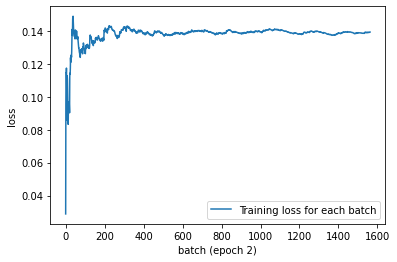

In [8]:
class LossHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs):
        self.per_batch_loss = []

    def on_batch_end(self, batch, logs):
        self.per_batch_loss.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):

        plt.clf()
        plt.plot(range(len(self.per_batch_loss)), self.per_batch_loss, label="Training loss for each batch")
        plt.xlabel(f"batch (epoch {epoch})")
        plt.ylabel("loss")
        plt.legend()
        plt.savefig(f"./figs/ch07_plot_at_epoch_{epoch}")
        self.per_batch_loss = []

model4 = get_minst_model()

model4.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model4.fit(train_images, train_labels,
          epochs=3,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))



**Tenorboard**

In [9]:
model5 = get_minst_model()

model5.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="./logs/"
)

model5.fit(train_images, train_labels,
          epochs=3,
          callbacks=[tensorboard],
          validation_data=(val_images, val_labels))

Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2904 - accuracy: 0.9137 - val_loss: 0.1448 - val_accuracy: 0.9587
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1652 - accuracy: 0.9540 - val_loss: 0.1199 - val_accuracy: 0.9658
Epoch 3/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1398 - accuracy: 0.9626 - val_loss: 0.1108 - val_accuracy: 0.9720


In [10]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 16342), started 2:07:48 ago. (Use '!kill 16342' to kill it.)

In [11]:
from numba import cuda
cuda.select_device(0)
cuda.close()